In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = "/content/drive/MyDrive/chicken-breed-identification/dataset/train"

epochs = 10
batch_size = 32
img_width = 224
img_height = 224

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print("")

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print("Classes : ")
class_names = train_ds.class_names
print(class_names)
print("")

Found 6335 files belonging to 12 classes.
Using 5068 files for training.

Found 6335 files belonging to 12 classes.
Using 1267 files for validation.
Classes : 
['Barred Plymouth Rock', 'Black Australorp', 'Blackstar', 'Brahma', 'Decalb Brown', 'Hubbard Sasso', 'Jersery Giant', 'Kabir', 'Peruvian Black Knight', 'Rhode Island Red', 'RhodeIslandWhite', 'Shamo']




(32, 224, 224, 3)
(32,)


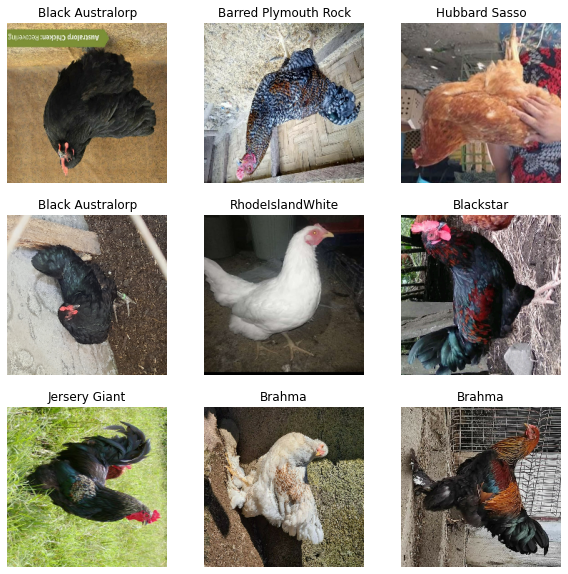

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

print("")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0044555957 1.0


In [7]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


159/159 [==============================] - 199s 1s/step - loss: 1.9289 - accuracy: 0.3041 - val_loss: 1.4776 - val_accuracy: 0.4680
Epoch 2/10
159/159 [==============================] - 10s 63ms/step - loss: 1.2127 - accuracy: 0.5673 - val_loss: 1.2074 - val_accuracy: 0.5809
Epoch 3/10
159/159 [==============================] - 10s 62ms/step - loss: 0.7075 - accuracy: 0.7587 - val_loss: 1.0388 - val_accuracy: 0.6622
Epoch 4/10
159/159 [==============================] - 10s 62ms/step - loss: 0.3164 - accuracy: 0.8988 - val_loss: 1.1379 - val_accuracy: 0.6819
Epoch 5/10
159/159 [==============================] - 10s 62ms/step - loss: 0.1258 - accuracy: 0.9680 - val_loss: 1.4205 - val_accuracy: 0.7001
Epoch 6/10
159/159 [==============================] - 10s 62ms/step - loss: 0.0611 - accuracy: 0.9866 - val_loss: 1.6251 - val_accuracy: 0.7017
Epoch 7/10
159/159 [==============================] - 10s 62ms/step - loss: 0.0463 - accuracy: 0.9909 - val_loss: 1.6119 - val_accuracy: 0.7009
Epoc

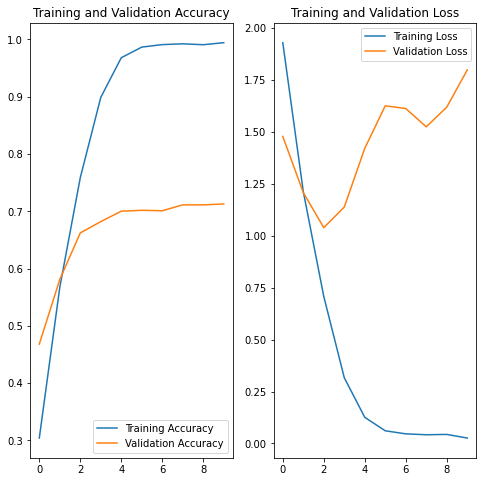

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
scores = model.evaluate(val_ds)
print("Accuracy : %.2f%%" % (scores[1] * 100))

40/40 [==============================] - 1s 21ms/step - loss: 1.7976 - accuracy: 0.7127
Accuracy : 71.27%


In [12]:
# def predict_image(img):
#   img_4d=img.reshape(-1, 224, 224,3)
#   prediction=model.predict(img_4d)[0]
#   return {class_names[i]: float(prediction[i]) for i in range(len(class_names))}

# !pip install gradio
# import gradio as gr

In [13]:
# image = gr.inputs.Image(shape=(224,224))
# label = gr.outputs.Label()

# gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

In [14]:
# !pip install tensorflowjs

# model.save('/content/drive/MyDrive/chicken-breed-identification/dataset/model/main/keras_model.h5')
# !tensorflowjs_converter --input_format=keras '/content/drive/MyDrive/chicken-breed-identification/dataset/model/main/keras_model.h5' '/content/drive/MyDrive/chicken-breed-identification/dataset/model/main'
# print("Model saved and converted!")

In [15]:
# from tensorflow.keras import applications

# mobileNetModel = applications.mobilenet.MobileNet()
# mobileNetModel.save('/content/drive/MyDrive/chicken-breed-identification/dataset/model/mobilenet/keras_model.h5')
# !tensorflowjs_converter --input_format=keras '/content/drive/MyDrive/chicken-breed-identification/dataset/model/mobilenet/keras_model.h5' '/content/drive/MyDrive/chicken-breed-identification/dataset/model/mobilenet'
# print("Model saved and converted!")